![alt text](04_respiratory_metrics.png)

# getting what the network is learning 

In [1]:
import torch
import torch.utils.data
from torch.utils.data import TensorDataset

import argparse
import time
import gc
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

from tqdm.notebook import tqdm

import wandb
import os

from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, matthews_corrcoef

In [2]:
import h5py
import numpy as np
from loader import ICUVariableLengthLoaderTables, ICUVariableLengthDataset
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [699]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib import cm

In [3]:
torch.manual_seed(0)
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 4060 Ti')

In [4]:
import gc
gc.collect()

11

In [5]:
from net_dev_graph import GNNStack
# from utils_todynet_binary import AverageMeter, accuracy, log_msg, get_default_train_val_test_loader

In [6]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

## aruguments

In [7]:
args = {
    'arch': 'dyGIN2d', #what other models I can put here?? dyGCN2d, dyGIN2d
    'dataset': 'Resp_failure_development_attentionMSE', # "AtrialFibrillation" # 'Mortality', # 'MIMIC3' Resp_failure
    'num_layers': 2,  # the number of GNN layers  3
    'groups': 32,#32  # the number of time series groups (num_graphs)
    'pool_ratio': 0.0,  # the ratio of pooling for nodes # initially 0.1 but changed to 0 because the node number was decreasing
    'kern_size': [3,3],  # list of time conv kernel size for each layer [9,5,3]
    'in_dim': 64,  # input dimensions of GNN stacks
    'hidden_dim': 64,  # hidden dimensions of GNN stacks
    'out_dim': 64,  # output dimensions of GNN stacks
    'workers': 0,  # number of data loading workers
    'epochs': 20,  # number of total epochs to run
    'batch_size': 4,  # mini-batch size, this is the total batch size of all GPUs
    'val_batch_size': 4,  # validation batch size
    'lr': 0.0002,  # initial learning rate
    'weight_decay': 1e-4,  # weight decay
    'evaluate': False,  # evaluate model on validation set
    'seed': 3,  # seed for initializing training
    'gpu': 0,  # GPU id to use
    'use_benchmark': True,  # use benchmark
    'tag': 'date',  # the tag for identifying the log and model files
    'loss':'bce',
    'resample':'5min',
    'series_length':2016,
}

# resample works: 5min, 15 min, 35 min, 45min. analysis will have 5,15,45

### TODO
## Molly douglas has filtered 116 features from 231, ~50% reduction

In [8]:
# # start a new wandb run to track this script
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="mortality",
    
#     # track hyperparameters and run metadata
#     config=args
# )

In [9]:
# train_dataset = TensorDataset(data_train, label_train)
# val_dataset   = TensorDataset(data_val, label_val)

In [10]:
# train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=args['batch_size'],shuffle=True, num_workers=args['workers'], pin_memory=True)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=args['val_batch_size'], shuffle=False,num_workers=args['workers'],pin_memory=True)

In [11]:
# def main():
#     # args = parser.parse_args()
    
#     # args.kern_size = [ int(l) for l in args.kern_size.split(",") ]

#     # if args.seed is not None:
#     random.seed(args['seed'])
#     torch.manual_seed(args['seed'])

#     main_work(args)

In [12]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    
    
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
              
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        
        # print(output, target)

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            try:
                res.append(correct_k.mul_(100.0 / batch_size))
            except:
                res.append(0)

        return res

def log_msg(message, log_file):
    with open(log_file, 'a') as f:
        print(message, file=f)


def get_default_train_val_test_loader(args):

    # get dataset-id
    dsid = args['dataset']
    h5_path= 'h5_folder/ml_stage_12h.h5'
    # get dataset from .pt
    # data_train  = torch.load(f'data/UCR/{dsid}/X_train.pt')
    # data_val    = torch.load(f'data/UCR/{dsid}/X_valid.pt')
    # data_val    = torch.load(f'data/UCR/{dsid}/X_test.pt')
    
    # label_train = torch.load(f'data/UCR/{dsid}/y_train.pt')
    # label_val   = torch.load(f'data/UCR/{dsid}/y_valid.pt')
    # label_val   = torch.load(f'data/UCR/{dsid}/y_test.pt')

    # label_train = label_train.flatten().to(dtype=torch.int64)
    # label_val   = label_val.flatten().to(dtype=torch.int64)
    # init [num_variables, seq_length, num_classes]
    
    num_nodes = 231
    seq_length = 2016 #864 #288 #2016 ### now we will reduce the sequence length to see the performance in short-range
    num_classes = 2


    # convert data & labels to TensorDataset
    # train_dataset = TensorDataset(data_train, label_train)
    # val_dataset = TensorDataset(data_val, label_val)
    
#     task              = 'Mortality_At24Hours'
#     maxlen            = 288                                                                             #patients| pos  | neg |
#     data_loader_train = ICUVariableLengthDataset(source_path=h5_path, maxlen=maxlen, task=task, split='train') #10524   | 9613 | 911 |
#     data_loader_val   = ICUVariableLengthDataset(source_path=h5_path, maxlen=maxlen, task=task, split='val')   #2205    | 2048 | 157 |
#     data_loader_test  = ICUVariableLengthDataset(source_path=h5_path, maxlen=maxlen, task=task, split='test')  #2231    | 2045 | 186 |
    
    
    
    task   = 'Dynamic_RespFailure_12Hours' ##27249
    maxlen            = 2016 #864 #288 #2016                                                                         #|patients|    #-1 =8065                    #2016                      #difference
    data_loader_train = ICUVariableLengthDataset(source_path=h5_path, maxlen=maxlen, task=task, split='train') #| 19092  |    5646423(3467116+2179307)     4776429(2901908+1874521)   869994(565208+304786)
    data_loader_val   = ICUVariableLengthDataset(source_path=h5_path, maxlen=maxlen, task=task, split='val')   #| 4081   |    1220285(758822+461463)       1006329(614326+392003)     213956(144496+69460)
    data_loader_test  = ICUVariableLengthDataset(source_path=h5_path, maxlen=maxlen, task=task, split='test')  #| 4076   |    1209724(753935+455789)       1015139(620532+394607)     194585(133403+61182)
    
    train_loader = DataLoader(data_loader_train, batch_size=args['batch_size'], shuffle=True, num_workers=1,pin_memory=True, prefetch_factor=2)
    val_loader   = DataLoader(data_loader_val,   batch_size=args['batch_size'], shuffle=False, num_workers=1,pin_memory=True, prefetch_factor=2)
    # val_loader  = DataLoader(data_loader_test,  batch_size=4, shuffle=False, num_workers=1,pin_memory=True, prefetch_factor=2)
    test_loader  = DataLoader(data_loader_test,  batch_size=args['batch_size'], shuffle=False, num_workers=1,pin_memory=True, prefetch_factor=2)


    # data_loader
    # train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=args['batch_size'],shuffle=True,num_workers=args['workers'], pin_memory=True)
    # val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=args['val_batch_size'],shuffle=False,num_workers=args['workers'],pin_memory=True)


    return train_loader, val_loader, test_loader, num_nodes, seq_length, num_classes

In [13]:
def get_default_test_loader(args):

    # get dataset-id
    dsid = args['dataset']
    h5_path= 'h5_folder/ml_stage_12h.h5'
    
    num_nodes = 231
    seq_length = 2016 #864 #288 #2016 ### now we will reduce the sequence length to see the performance in short-range
    num_classes = 2
   
    
    task   = 'Dynamic_RespFailure_12Hours' ##27249
    maxlen            = 2016 #864 #288 #2016                                                                         #|patients|    #-1 =8065                    #2016                      #difference
    data_loader_test  = ICUVariableLengthDataset(source_path=h5_path, maxlen=maxlen, task=task, split='test')  #| 4076   |    1209724(753935+455789)       1015139(620532+394607)     194585(133403+61182)
    
    test_loader  = DataLoader(data_loader_test,  batch_size=8, shuffle=False, num_workers=1,pin_memory=True, prefetch_factor=2)


    return test_loader, num_nodes, seq_length, num_classes

In [14]:
def main_work(args):
    
    random.seed(args['seed'])
    torch.manual_seed(args['seed'])
    
    
    # init metrics
    best_acc1 = 0
    best_roc  = 0
    best_pr   = 0
    best_f1   = 0
    best_mcc  = 0
    
    best_test_acc1 = 0
    best_test_roc  = 0
    best_test_pr   = 0
    best_test_f1   = 0
    best_test_mcc  = 0    
    
    if args['tag'] == 'date':
        local_date = time.strftime('%m.%d %H:%M', time.localtime(time.time()))
        args['tag'] = local_date
        
    # Use the 'tag' which now contains either the date or a custom tag along with the dataset name for the directory
    run_dir_name = f"{args['dataset']}_{args['tag']}"
   
    # Base directory for saving models
    base_model_save_dir = "saved_models"
   
    # Specific directory for this run
    specific_model_save_dir = os.path.join(base_model_save_dir, run_dir_name)
    os.makedirs(specific_model_save_dir, exist_ok=True)

    print(f"Models will be saved in: {specific_model_save_dir}")        


    log_file = 'log/{}_gpu{}_{}_{}_exp.txt'.format(args['tag'], args['gpu'], args['arch'], args['dataset'])
    
    
    if args['gpu'] is not None:
        print("Use GPU: {} for training".format(args['gpu']))


    # dataset
    train_loader, val_loader, test_loader, num_nodes, seq_length, num_classes = get_default_train_val_test_loader(args)
    
    print('features / nodes', num_nodes,'total time graphs',args['groups'],'time series length',seq_length,'classes', num_classes)
    
    # training model from net.py
    model = GNNStack(gnn_model_type=args['arch'], num_layers=args['num_layers'], 
                     groups=args['groups'], pool_ratio=args['pool_ratio'], kern_size=args['kern_size'], 
                     in_dim=args['in_dim'], hidden_dim=args['hidden_dim'], out_dim=args['out_dim'], 
                     seq_len=seq_length, num_nodes=num_nodes, num_classes=num_classes)

    # print & log
    log_msg('epochs {}, lr {}, weight_decay {}'.format(args['epochs'], args['lr'], args['weight_decay']), log_file)
    
    log_msg(str(args), log_file)


    # determine whether GPU or not
    if not torch.cuda.is_available():
        print("Warning! Using CPU!!!")
    elif args['gpu'] is not None:
        torch.cuda.set_device(args['gpu'])

        # collect cache
        gc.collect()
        torch.cuda.empty_cache()

        model = model.cuda(args['gpu'])
        if args['use_benchmark']:
            cudnn.benchmark = True
        print('Using cudnn.benchmark.')
    else:
        print("Error! We only have one gpu!!!")


    # define loss function(criterion) and optimizer
    # class_weights = torch.tensor([0.087, 0.913], dtype=torch.float).cuda(args['gpu'])
    # class_weights = torch.tensor([0.913, 0.087], dtype=torch.float).cuda(args['gpu'])
    # class_weights = torch.tensor([1.0, 22.47], dtype=torch.float).cuda(args['gpu'])
    
    
    # criterion = nn.CrossEntropyLoss(weight=class_weights).cuda(args['gpu'])
    
    criterion = nn.CrossEntropyLoss().cuda(args['gpu'])
    
    # TODO
    # criterion = FocalLoss(gamma=0.1)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
    
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

    # validation
    if args['evaluate']:
        validate(val_loader, model, criterion, args)
        return

    # train & valid
    print('****************************************************')
    print('Dataset: ', args['dataset'])

    dataset_time = AverageMeter('Time', ':6.3f')

    loss_train = []
    acc_train = []
    loss_val = []
    acc_val = []
    epoches = []
    
    ########################
    loss_test = []
    acc_test  = []
    #######################
    
    ###### more lists to have values
    roc_train = []
    pr_train  = []
    f1_train  = []
    mcc_train = []
    
    roc_val   = []
    pr_val    = []
    f1_val    = []
    mcc_val   = []
    ##################################################
    roc_test   = []
    pr_test    = []
    f1_test    = []
    mcc_test   = []     
    #################################################
    end = time.time()
    for epoch in tqdm(range(args['epochs'])):
    # for epoch in range(args['epochs']):
        epoches += [epoch]

        # train for one epoch
        acc_train_per, loss_train_per, output_train_per, target_train_per = train(train_loader, model, criterion, optimizer, lr_scheduler, args)
        
        acc_train += [acc_train_per]
        loss_train += [loss_train_per]
        # calculate metric
        # print(len(target_train_per),len(output_train_per))
        auc_roc_value_train = roc_auc_score(target_train_per, output_train_per)
        auc_pr_value_train = average_precision_score(target_train_per, output_train_per)
        p2l_value_train = np.where(np.array(output_train_per) >= 0.5, 1, 0)
        f1_value_train = f1_score(target_train_per, p2l_value_train.tolist())
        mcc_value_train= matthews_corrcoef(target_train_per,p2l_value_train.tolist())
        
        #new code
        roc_train += [auc_roc_value_train]
        pr_train  += [auc_pr_value_train]
        f1_train  += [f1_value_train]
        mcc_train  += [mcc_value_train]

        msg = f'TRAIN, epoch {epoch}, train_loss {loss_train_per}, train_acc {acc_train_per}, train_roc {auc_roc_value_train:.5f}, \
                train_pr {auc_pr_value_train:.5f}, train_f1 {f1_value_train:.5f},train_mcc {mcc_value_train:.5f}'

        print(f'TRAIN, epoch {epoch}, train_loss {loss_train_per:.5f}, train_roc {auc_roc_value_train:.5f}, train_pr {auc_pr_value_train:.5f}, train_f1 {f1_value_train:.5f}, train_mcc {mcc_value_train:.5f}')
        # tqdm.write(f'TRAIN, epoch {epoch}, train_loss {loss_train_per:.5f}, train_roc {auc_roc_value_train:.5f}, train_pr {auc_pr_value_train:.5f}, train_f1 {f1_value_train:.5f}, train_mcc {mcc_value_train:.5f}')
        log_msg(msg, log_file)

        
        # evaluate on validation set
        acc_val_per, loss_val_per, output_val_per, target_val_per = validate(val_loader, model, criterion, args)

        acc_val  += [acc_val_per]
        loss_val += [loss_val_per]
        #calculate metric
        # calculate metric
        # print(len(target_val_per),len(output_val_per))
        auc_roc_value_val = roc_auc_score(target_val_per, output_val_per)
        auc_pr_value_val = average_precision_score(target_val_per, output_val_per)
        p2l_value_val = np.where(np.array(output_val_per) >= 0.5, 1, 0)
        f1_value_val = f1_score(target_val_per, p2l_value_val.tolist())
        mcc_value_val= matthews_corrcoef(target_val_per,p2l_value_val.tolist())
        #new code

        msg = f'VAL, epoch {epoch}, val_loss {loss_val_per}, val_acc {acc_val_per}, val_roc {auc_roc_value_val:.5f}, val_pr {auc_pr_value_val:.5f},val_f1 {f1_value_val:.5f}, val_mcc {mcc_value_val:.5f}'
        
        print(f'VAL, epoch {epoch}, val_loss {loss_val_per:.5f}, val_roc {auc_roc_value_val:.5f}, val_pr {auc_pr_value_val:.5f},val_f1 {f1_value_val:.5f}, val_mcc {mcc_value_val:.5f}')
        # tqdm.write(f'VAL, epoch {epoch}, val_loss {loss_val_per:.5f}, val_roc {auc_roc_value_val:.5f}, val_pr {auc_pr_value_val:.5f},val_f1 {f1_value_val:.5f}, val_mcc {mcc_value_val:.5f}')
        log_msg(msg, log_file)
        #########################################################################################################################
        # evaluate on test set
        acc_test_per, loss_test_per, output_test_per, target_test_per = validate(test_loader, model, criterion, args)

        acc_test   += [acc_test_per]
        loss_test  += [loss_test_per]
        #calculate metric
        # calculate metric
        # print(len(target_val_per),len(output_val_per))
        auc_roc_value_test = roc_auc_score(target_test_per, output_test_per)
        auc_pr_value_test  = average_precision_score(target_test_per, output_test_per)
        p2l_value_test = np.where(np.array(output_test_per) >= 0.5, 1, 0)
        f1_value_test = f1_score(target_test_per, p2l_value_test.tolist())
        mcc_value_test= matthews_corrcoef(target_test_per,p2l_value_test.tolist())
        #new code

        msg = f'TEST, epoch {epoch},test_loss {loss_test_per},test_acc {acc_test_per},test_roc {auc_roc_value_test:.5f},test_pr {auc_pr_value_test:.5f},test_f1 {f1_value_test:.5f}, test_mcc {mcc_value_test:.5f}'
        print(f'TEST, epoch {epoch}, test_loss {loss_test_per:.5f}, test_roc {auc_roc_value_test:.5f}, test_pr {auc_pr_value_test:.5f}, test_f1 {f1_value_test:.5f}, test_mcc {mcc_value_test:.5f}')
        # tqdm.write(f'TEST, epoch {epoch}, test_loss {loss_test_per:.5f}, test_roc {auc_roc_value_test:.5f}, test_pr {auc_pr_value_test:.5f}, test_f1 {f1_value_test:.5f}, test_mcc {mcc_value_test:.5f}')
        log_msg(msg, log_file)        
        
        #########################################################################################################################
        # remember best acc
        best_acc1 = max(acc_val_per, best_acc1)
        best_roc  = max(auc_roc_value_val, best_roc)
        best_pr   = max(auc_pr_value_val, best_pr)
        best_f1   = max(f1_value_val, best_f1)
        best_mcc   = max(mcc_value_val, best_mcc)
        
        #########################################################################################################################
        
        best_test_acc1 = max(acc_test_per, best_test_acc1)
        best_test_roc  = max(auc_roc_value_test, best_test_roc)
        best_test_pr   = max(auc_pr_value_test, best_test_pr)
        best_test_f1   = max(f1_value_test, best_test_f1)
        best_test_mcc   = max(mcc_value_test, best_test_mcc)
 

    #     wandb.log({"train_loss": loss_train_per, "train_roc": auc_roc_value_train, "train_pr": auc_pr_value_train, \
    #                "val_loss": loss_val_per, "val_roc": auc_roc_value_val, "val_pr": auc_pr_value_val, "best_val_roc": best_roc, "best_val_pr": best_pr})
    # wandb.finish()
    
    
    
        # Construct the filename with metrics
        auc_roc_value_val_scalar = auc_roc_value_val.item() if isinstance(auc_roc_value_val, torch.Tensor) else auc_roc_value_val
        auc_pr_value_val_scalar  = auc_pr_value_val.item() if isinstance(auc_pr_value_val, torch.Tensor) else auc_pr_value_val
        f1_value_val_scalar      = f1_value_val.item() if isinstance(f1_value_val, torch.Tensor) else f1_value_val
        mcc_value_val_scalar     = mcc_value_val.item() if isinstance(mcc_value_val, torch.Tensor) else mcc_value_val
        #########################################################################################################################
        auc_roc_value_test_scalar = auc_roc_value_test.item() if isinstance(auc_roc_value_test, torch.Tensor) else auc_roc_value_test
        auc_pr_value_test_scalar  = auc_pr_value_test.item() if isinstance(auc_pr_value_test, torch.Tensor) else auc_pr_value_test
        f1_value_test_scalar      = f1_value_test.item() if isinstance(f1_value_test, torch.Tensor) else f1_value_test
        mcc_value_test_scalar      = mcc_value_test.item() if isinstance(mcc_value_test, torch.Tensor) else mcc_value_test        
        #########################################################################################################################
        # Now use these scalar values in the filename
        filename = f"model_epoch_{epoch}.pth"
       
        # Continue with the existing logic to save the model
        model_path = os.path.join(specific_model_save_dir, filename)
        torch.save(model.state_dict(), model_path)

    # measure elapsed time
    dataset_time.update(time.time() - end)

    # log & print the best_acc
    msg = f'\n\n * BEST_ACC: {best_acc1}\n * TIME: {dataset_time}\n'
    log_msg(msg, log_file)

    print(f' * best_acc1: {best_acc1}, best_roc: {best_roc}, best_pr: {best_pr}, best_f1: {best_f1}, best_mcc: {best_mcc}')
    print(f' * best_test_acc1: {best_test_acc1}, best_test_roc: {best_test_roc}, best_test_pr: {best_test_pr}, best_test_f1: {best_test_f1}, best_test_mcc: {best_test_mcc}')
    print(f' * time: {dataset_time}')
    print('****************************************************')


    # collect cache
    gc.collect()
    torch.cuda.empty_cache()


def train(train_loader, model, criterion, optimizer, lr_scheduler, args):
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc', ':6.2f')
    # met_roc = AverageMeter('ROC', ':6.2f')
    # met_pr = AverageMeter('PR', ':6.2f')
    
    output_list = []
    target_list = [] 

    # switch to train mode
    model.train()

    for count, (data, label, mask) in enumerate(train_loader):

        # data in cuda
        data = data.cuda(args['gpu']).type(torch.float)
        data = data.view(data.size(0), 1, data.size(2), data.size(1))
        mask = mask.cuda(args['gpu']).type(torch.bool)
        label = label.cuda(args['gpu']).type(torch.long)

        # compute output
        # output = model(data)
        output,feature_time_maps, adj_matrices, wadj_matrices = model(data)
        # print(len(output))
        # print('output', output.shape, 'mask', mask.shape)
        out_flat = torch.masked_select(output, mask.unsqueeze(-1)).reshape(-1, output.shape[-1])
        # print(output)
        # print(output.shape, mask.shape, out_flat.shape)
        # break
        # out_flat = torch.masked_select(output[:,:,1], mask)
        

        label_flat = torch.masked_select(label, mask)
        # print('output',output.shape, 'mask', mask.shape,'out_flat', out_flat.shape, 'label', label.shape, 'label_flat', label_flat.shape)
        loss = criterion(out_flat, label_flat)

        # measure accuracy and record loss
        acc1 = accuracy(out_flat, label_flat, topk=(1, 1))
        
        output_np = torch.softmax(out_flat, dim=1).detach().cpu().numpy()[:,1].tolist()
        
        target_np = label_flat.detach().cpu().numpy().tolist()
        
        # print(output_np, target_np)
        
        losses.update(loss.item(), data.size(0))
        top1.update(acc1[0], data.size(0))
        
        # met_roc.update(roc, data.size(0))
        # met_pr.update(pr, data.size(0))
        output_list += output_np
        target_list += target_np

        # compute gradient and do Adam step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    lr_scheduler.step(top1.avg)

    return top1.avg, losses.avg, output_list, target_list


def validate(val_loader, model, criterion, args):
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    # met_roc = AverageMeter('ROC', ':6.2f')
    # met_pr = AverageMeter('PR', ':6.2f')
    output_list = []
    target_list = [] 
    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        for count, (data, label, mask) in enumerate(val_loader):
            if args['gpu'] is not None:
                data = data.cuda(args['gpu'], non_blocking=True).type(torch.float)
                data = data.view(data.size(0), 1, data.size(2), data.size(1))
            if torch.cuda.is_available():
                label = label.cuda(args['gpu'], non_blocking=True).type(torch.long)
                mask  = mask.cuda(args['gpu'], non_blocking=True).type(torch.bool)

            # compute output
            # output = model(data)
            output, feature_time_maps, adj_matrices, wadj_matrices = model(data)
            
            out_flat = torch.masked_select(output, mask.unsqueeze(-1)).reshape(-1, output.shape[-1])
            label_flat = torch.masked_select(label, mask)

            loss = criterion(out_flat, label_flat)
            
            output_np = torch.softmax(out_flat, dim=1).detach().cpu().numpy()[:,1].tolist()
            target_np = label_flat.detach().cpu().numpy().tolist()

            # measure accuracy and record loss
            acc1 = accuracy(out_flat, label_flat, topk=(1, 1))
            losses.update(loss.item(), data.size(0))
            top1.update(acc1[0], data.size(0))
            
            output_list += output_np
            target_list += target_np
            
            # met_roc.update(roc, data.size(0))
            # met_pr.update(pr, data.size(0))

    return top1.avg, losses.avg, output_list, target_list

def load_model(model_path, model_class, model_kwargs):
    """
    Load a model from a saved state dictionary.

    Parameters:
    - model_path: str, path to the saved model state dictionary.
    - model_class: class, the class of the model to instantiate.
    - model_kwargs: dict, keyword arguments for model class instantiation.

    Returns:
    - model: an instance of model_class with weights loaded from model_path.
    """
    # Instantiate the model with the provided keyword arguments
    model = model_class(**model_kwargs)
    
    # Load the state dictionary
    model.load_state_dict(torch.load(model_path))

    model = model.cuda(args['gpu'])
    # Set the model to evaluation mode
    model.eval()
    
    return model

In [70]:
def validate_extract(val_loader, model, criterion, args):
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    # met_roc = AverageMeter('ROC', ':6.2f')
    # met_pr = AverageMeter('PR', ':6.2f')
    output_list = []
    target_list = [] 
    featuretime_list = []
    adj_list = []
    wadj_list = []
    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        for count, (data, label, mask) in enumerate(val_loader):
            if args['gpu'] is not None:
                data = data.cuda(args['gpu'], non_blocking=True).type(torch.float)
                data = data.view(data.size(0), 1, data.size(2), data.size(1))
            if torch.cuda.is_available():
                label = label.cuda(args['gpu'], non_blocking=True).type(torch.long)
                mask  = mask.cuda(args['gpu'], non_blocking=True).type(torch.bool)

            # compute output
            # output = model(data)
            output, feature_time_maps, adj_matrices, wadj_matrices = model(data)
            
            out_flat = torch.masked_select(output, mask.unsqueeze(-1)).reshape(-1, output.shape[-1])
            label_flat = torch.masked_select(label, mask)

            loss = criterion(out_flat, label_flat)
            
            output_np = torch.softmax(out_flat, dim=1).detach().cpu().numpy()[:,1].tolist()
            target_np = label_flat.detach().cpu().numpy().tolist()

            # measure accuracy and record loss
            acc1 = accuracy(out_flat, label_flat, topk=(1, 1))
            losses.update(loss.item(), data.size(0))
            top1.update(acc1[0], data.size(0))
            
            output_list += output_np
            target_list += target_np

            featuretime_list += feature_time_maps
            adj_list += adj_matrices
            wadj_list += wadj_matrices
            
            if count >= 7:
                break # putting all the matrices into memory causes crash - just get the first eight batches
            
            # break ## putting all the matrices into memory causes crash - just get the first batch
            #TODO
            # efficient way to extract particular matrices
            # met_roc.update(roc, data.size(0))
            # met_pr.update(pr, data.size(0))

    # return top1.avg, losses.avg, output_list, target_list, feature_time_maps, adj_matrices, wadj_matrices
    return top1.avg, losses.avg, output_list, target_list, featuretime_list, adj_list, wadj_list

In [71]:
# main_work(args)

#### plots

In [72]:
model_kwargs = {
    'gnn_model_type': args['arch'],
    'num_layers': args['num_layers'],
    'groups': args['groups'],
    'pool_ratio': args['pool_ratio'],
    'kern_size': args['kern_size'],
    'in_dim': args['in_dim'],
    'hidden_dim': args['hidden_dim'],
    'out_dim': args['out_dim'],
    'seq_len': 2016, 
    'num_nodes': 231,  
    'num_classes': 2  
}

In [73]:
# Example usage
model_path = 'saved_models/Resp_failure_development_attentionMSE_03.05 00:14/model_epoch_7.pth'

In [74]:
model = load_model(model_path, GNNStack, model_kwargs)

In [75]:
test_loader, num_nodes, seq_length, num_classes = get_default_test_loader(args)

In [76]:
criterion = nn.CrossEntropyLoss().cuda(args['gpu'])

In [77]:
# model

In [78]:
# top1_avg_valid, losses_avg_valid, output_list, target_list, feature_time_maps, adj_matrices, wadj_matrices = validate_extract(test_loader, model, criterion, args)

In [79]:
top1_avg_valid, losses_avg_valid, output_list, target_list, featuretime_list, adj_list, wadj_list = validate_extract(test_loader, model, criterion, args)

In [80]:
len(featuretime_list), len(adj_list), len(wadj_list) ### bcz there are two layers

(16, 16, 16)

In [971]:
import pickle

In [972]:
with open('featuretime_list.pkl', 'wb') as file1:
    pickle.dump(featuretime_list, file1)
with open('adj_list.pkl', 'wb') as file2:
    pickle.dump(adj_list, file2)
with open('wadj_list.pkl', 'wb') as file3:
    pickle.dump(wadj_list, file3)


In [606]:
# featuretime_list[0].shape, featuretime_list[1].shape, featuretime_list[2].shape, featuretime_list[3].shape,   \
# featuretime_list[4].shape, featuretime_list[5].shape, featuretime_list[6].shape, featuretime_list[7].shape,   \
# featuretime_list[8].shape, featuretime_list[9].shape, featuretime_list[10].shape, featuretime_list[11].shape, \
# featuretime_list[12].shape, featuretime_list[13].shape, featuretime_list[14].shape, featuretime_list[15].shape,

In [82]:
adj_list[0].shape

(32, 231, 231)

In [607]:
# adj_list[0].shape, adj_list[1].shape, adj_list[2].shape, adj_list[3].shape,   \
# adj_list[4].shape, adj_list[5].shape, adj_list[6].shape, adj_list[7].shape,   \
# adj_list[8].shape, adj_list[9].shape, adj_list[10].shape, adj_list[11].shape, \
# adj_list[12].shape, adj_list[13].shape, adj_list[14].shape, adj_list[15].shape,
# ### its the same graph for each layer - because it is the adjacency matrix

In [608]:
# wadj_list[0].shape, wadj_list[1].shape, wadj_list[2].shape, wadj_list[3].shape,   \
# wadj_list[4].shape, wadj_list[5].shape, wadj_list[6].shape, wadj_list[7].shape,   \
# wadj_list[8].shape, wadj_list[9].shape, wadj_list[10].shape,wadj_list[11].shape, \
# wadj_list[12].shape,wadj_list[13].shape,wadj_list[14].shape,wadj_list[15].shape,

### these are different graphs because they are feature-feature interactions obtained using the attention based time diff layer

## club everything together

In [119]:
# Separate the matrices by layer
featuretime_list_layer1 = [featuretime_list[i] for i in range(len(featuretime_list)) if i % 2 == 0]
featuretime_list_layer2 = [featuretime_list[i] for i in range(len(featuretime_list)) if i % 2 != 0]

# Concatenate the matrices for each layer
featuretime_layer_1 = np.concatenate(featuretime_list_layer1, axis=0)
featuretime_layer_2 = np.concatenate(featuretime_list_layer2, axis=0)

In [120]:
featuretime_layer_1.shape, featuretime_layer_2.shape

((64, 64, 231, 2016), (64, 64, 231, 2016))

In [973]:
np.save('featuretime_layer_1.npy', featuretime_layer_1)
np.save('featuretime_layer_2.npy', featuretime_layer_2)

In [121]:
# Separate the matrices by layer
wadj_list_layer1 = [wadj_list[i] for i in range(len(wadj_list)) if i % 2 == 0]
wadj_list_layer2 = [wadj_list[i] for i in range(len(wadj_list)) if i % 2 != 0]

# Concatenate the matrices for each layer
wadj_layer_1 = np.concatenate(wadj_list_layer1, axis=0)
wadj_layer_2 = np.concatenate(wadj_list_layer2, axis=0)

In [122]:
wadj_layer_1.shape, wadj_layer_2.shape

((64, 32, 231, 231), (64, 32, 231, 231))

In [974]:
np.save('wadj_layer_1.npy', wadj_layer_1)
np.save('wadj_layer_2.npy', wadj_layer_2)

In [123]:
# print(feature_time_maps[0].shape, feature_time_maps[1].shape, adj_matrices[0].shape, wadj_matrices[0].shape, adj_matrices[1].shape, wadj_matrices[1].shape)

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

In [470]:
data = np.load('testviz/testviz_data.npy')
labels = np.load('testviz/testviz_labels.npy')
mask = np.load('testviz/testviz_mask.npy')
label_flat =  np.load('testviz/testviz_label_flat.npy')

In [471]:
data.shape, labels.shape,mask.shape, label_flat.shape

((256, 2016, 231), (256, 2016), (256, 2016), (60204,))

In [794]:
pid = 51 ##55 works correctly, 44 works correctly, 51 is okay, 18- small rf

In [795]:
dtest_x = data[pid].T
## plot labels
dtest_y_2d = np.expand_dims(labels[pid], axis=0)

In [796]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Example 1D array
# data = dtest_y_2d[0]

# # Create a figure and an axes
# fig, ax = plt.subplots()

# # Plot the data
# # ax.plot(data, marker='o')

# # Function to find continuous occurrences of 1's and shift highlight by 144 steps
# def find_and_highlight_blocks(data, ax, shift=144):
#     start = None
#     for i in range(len(data)):
#         # Check if current element is 1 and we are not already in a block
#         if data[i] == 1 and start is None:
#             start = i
#         # Check if we reached the end of a block or the array
#         elif data[i] != 1 and start is not None:
#             end = i
#             # Highlight the block shifted by 144 steps, ensuring it does not exceed array bounds
#             ax.axvspan(max(0, start + shift), min(len(data), end + shift), color='yellow', alpha=0.5)
#             start = None
#     # Handle case where the last element is also 1
#     if start is not None:
#         ax.axvspan(max(0, start + shift), min(len(data), len(data) + shift), color='yellow', alpha=0.5)

# # Highlight continuous occurrences of 1's, shifted by 144 steps (adjust according to your array length)
# find_and_highlight_blocks(data, ax)

# # Additional customizations
# ax.set(xlabel='Index', ylabel='Value', title='Highlight Continuous 1\'s (Shifted)')

# # Show the plot
# plt.show()
# def find_and_highlight_blocks(data, ax, shift=144):
#     ax.axis('off')
#     start = None
#     for i in range(len(data)):
#         # Check if current element is 1 and we are not already in a block
#         if data[i] == 1 and start is None:
#             start = i
#         # Check if we reached the end of a block or the array
#         elif data[i] != 1 and start is not None:
#             end = i
#             # Highlight the block shifted by 144 steps, ensuring it does not exceed array bounds
#             ax.axvspan(max(0, start + shift), min(len(data), end + shift), color='green', alpha=1)
#             start = None
#     # Handle case where the last element is also 1
#     if start is not None:
#         ax.axvspan(max(0, start + shift), min(len(data), len(data) + shift), color='green', alpha=1)

# def find_and_highlight_blocks(data, ax, shift=144, label=None):
#     ax.axis('off')
#     start = None
#     for i in range(len(data)):
#         if data[i] == 1 and start is None:  # Start of a block
#             start = i
#         elif data[i] != 1 and start is not None:  # End of a block
#             # Highlight the block shifted by 144 steps with controlled height
#             ax.axvspan(max(0, start + shift), min(len(data), i + shift), color='green', alpha=1.0, ymin=0.5, ymax=0.6, label=label,  linewidth=10)
#             start = None
#             label = None  # Ensure label is only added once
#     # Handle case where the last element is also part of a block
#     if start is not None:
#         ax.axvspan(max(0, start + shift), min(len(data), len(data) + shift), color='green', alpha=1.0, ymin=0, ymax=1, label=label,  linewidth=10)

# def find_and_highlight_blocks(data, ax, shift=144):
#     ax.axis('off')
#     # Initially mark the entire shifted span in gray
#     for i in range(len(data)):
#         # Shift the entire span by 144, ensuring it does not exceed array bounds, and mark it gray
#         if i + shift < len(data):
#             ax.axvspan(i + shift, i + shift + 1, color='gray', alpha=0.5)
    
#     start = None
#     for i in range(len(data)):
#         # Check if current element is 1 and we are not already in a block
#         if data[i] == 1 and start is None:
#             start = i
#         # Check if we reached the end of a block or the array
#         elif data[i] != 1 and start is not None:
#             end = i
#             # Highlight the continuous block of 1's shifted by 144 steps in green
#             ax.axvspan(max(0, start + shift), min(len(data), end + shift), color='green', alpha=1)
#             start = None
#     # Handle case where the last element is also 1
#     if start is not None:
#         ax.axvspan(max(0, start + shift), min(len(data), len(data) + shift), color='green', alpha=1)

# def find_and_highlight_blocks(data, ax, shift=144):
#     ax.axis('off')

#     # Step 1: Initially mark the first 144 positions as mask (black) due to the shift
#     for i in range(min(shift, len(data))):  # Ensure we don't go beyond data length
#         ax.axvspan(i, i + 1, color='black', alpha=0.5)
    
#     # Step 2: Process the shift, preserving original mask and marking '1's green after the shift
#     for i in range(len(data)):
#         # Preserve original mask by marking positions with '0' in black, after shift
#         if data[i] == 0:
#             ax.axvspan(i + shift, i + shift + 1, color='black', alpha=0.5)
#         elif data[i] == 1:
#             # For '1's, mark the shifted position in green
#             if i + shift < len(data):  # Ensure the shifted position is within bounds
#                 ax.axvspan(i + shift, i + shift + 1, color='green', alpha=0.5)
#         else:  # For '-1' or any other values, continue to mark them as gray if not already masked
#             if i + shift < len(data):  # Check within bounds, and not overwriting original mask
#                 ax.axvspan(i + shift, i + shift + 1, color='gray', alpha=0.5)

# def visualize_with_original_mask(data, ax, shift=144):
#     ax.axis('off')  # Hide axis for clarity

#     # Determine the colors for each position after the shift
#     shifted_colors = ['gray'] * len(data)  # Default color for non-1 values

#     # Apply shift for '1's and mark them green, keeping within bounds
#     for i, val in enumerate(data):
#         if val == 1 and i + shift < len(data):
#             shifted_colors[i + shift] = 'green'

#     # Overlay the original mask (0 values) onto the shifted representation
#     for i, val in enumerate(data):
#         if val == 0:
#             shifted_colors[i] = 'black'  # Mask positions marked with black

#     # Visualize the result
#     for i, color in enumerate(shifted_colors):
#         ax.axvspan(i, i + 1, color=color, alpha=0.5)

#     # Adjust limits to match the data length
#     ax.set_xlim(0, len(data))

# def visualize_adjusted_shift_and_mask(data, ax, shift=144):
#     ax.axis('off')  # Hide axis for visual clarity

#     # Initialize all positions to gray
#     colors_after_shift = ['gray'] * len(data)
    
#     # Check the start for '1's and set initial shift span color
#     # initial_span_color = 'black' if 1 in data[:shift] else 'gray'
#     # for i in range(shift):
#     #     colors_after_shift[i] = initial_span_color

#     # Apply colors for shifted data, preserving the original mask
#     for i, val in enumerate(data):
#         if i + shift < len(data):
#             if val == 1:
#                 # Shift '1' values and color them green
#                 colors_after_shift[i + shift] = 'green'
    
#     # Overlay the original mask on the shifted visualization
#     for i, val in enumerate(data):
#         if val == 0:
#             # Preserve original '0' mask by marking it black
#             colors_after_shift[i] = 'black'

#     # Visualize the result with applied colors
#     for i, color in enumerate(colors_after_shift):
#         ax.axvspan(i, i + 1, color=color, alpha=1.0)

#     ax.set_xlim(0, len(data))
    
#     legend_elements = [Patch(facecolor='green', label='Yes'),
#                        Patch(facecolor='gray', label='No'),
#                        Patch(facecolor='black', label='Mask')]
#     # ax.legend(handles=legend_elements, loc='upper right', title="Respiratory Failure State",
#     ax.legend(handles=legend_elements, loc='upper right', title="RF State",
#              bbox_to_anchor=(1.12, 1.75),
#             # ncol=3
#              )

In [797]:
def visualize_with_corrected_initial_mask(data, ax, shift=144):
    ax.axis('off')  # Hide axis for clarity

    # Initialize all positions with gray, indicating inactive or unknown state
    shifted_colors = ['gray'] * len(data)

    # Correct the initial mask: first 'shift' positions should be black
    for i in range(shift):
        shifted_colors[i] = 'black'

    # Apply shift for '1's and mark them green, within bounds
    for i, val in enumerate(data):
        if val == 1 and i + shift < len(data):
            shifted_colors[i + shift] = 'green'

    # Overlay the original mask (0 values) onto the shifted representation, including initial black mask
    for i, val in enumerate(data):
        if val == 0:
            shifted_colors[i] = 'black'  # Preserve original mask positions with black

    # Visualize the result
    for i, color in enumerate(shifted_colors):
        ax.axvspan(i, i + 1, color=color, alpha=1.0)

    # Adjust limits to match the data length
    ax.set_xlim(0, len(data))
    legend_elements = [Patch(facecolor='green', label='Yes'),
                       Patch(facecolor='gray', label='No'),
                       Patch(facecolor='black', label='Mask')]
    # ax.legend(handles=legend_elements, loc='upper right', title="Respiratory Failure State",
    ax.legend(handles=legend_elements, loc='upper right', title="RF State",
             bbox_to_anchor=(1.12, 1.75),
            # ncol=3
             )
    

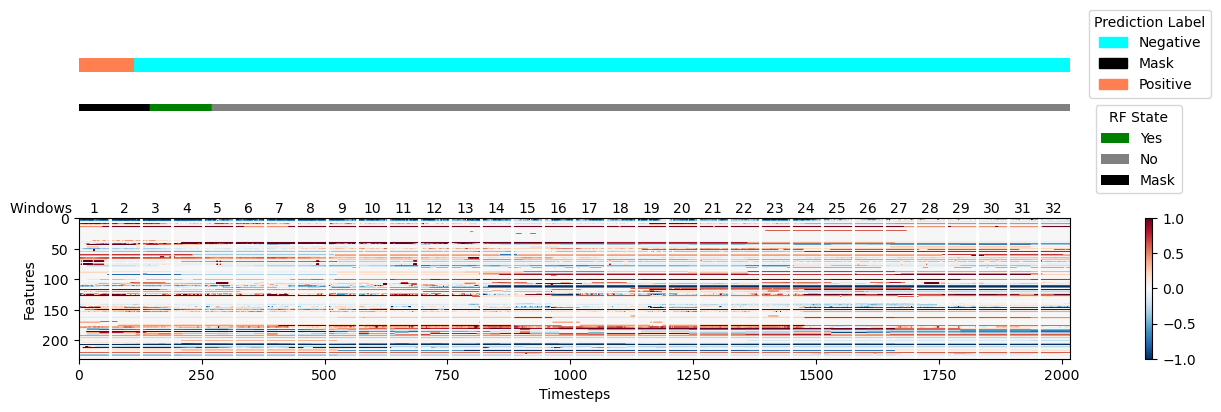

In [798]:
fig, axs = plt.subplots(3, 1, figsize=(12, 4), gridspec_kw={'height_ratios': [1,0.15,3]}, sharex=True,layout='constrained')

color_map = {-1: '#00FFFF', 0: 'black', 1: '#FF7F50'}
colors = np.vectorize(color_map.get)(dtest_y_2d)
# Bar plot adjusted to match the width of the plot below
for i, color in enumerate(colors.flatten()):
    axs[0].plot([i, i+1], [0, 0], color=color, linewidth=10)
axs[0].axis('off')
legend_labels = {-1: "Negative", 0: "Mask", 1: "Positive"}
legend_handles = [Patch(color=color, label=legend_labels[label]) for label, color in color_map.items()]
# Adjusting xlim to ensure the top bar matches the width of the plot below
axs[0].set_xlim(0, 2016)
axs[0].legend(handles=legend_handles, loc='center right', title="Prediction Label",
              bbox_to_anchor=(1.15, 0.75),
              # ncol=len(legend_handles)
             )
#########################################################################

# visualize_adjusted_shift_and_mask(data=dtest_y_2d[0].tolist(), ax=axs[1])
visualize_with_corrected_initial_mask(data=dtest_y_2d[0].tolist(), ax=axs[1])
# pos1 = axs[1].get_position()  # gets the position of the current subplot
# pos2 = [pos1.x0, pos1.y0 - 0.1,  pos1.width, pos1.height]  # Lower the subplot a bit
# axs[1].set_position(pos2)  # set a new position
########################################################################
# Feature-Time Visualization adjusted
im = axs[2].imshow(dtest_x, aspect='auto', cmap='RdBu_r',vmin=-1, vmax=1)
fig.colorbar(im, ax=axs[2], 
             location = 'right',
             orientation='vertical',
             # fraction=0.9,
             # aspect=2,
             pad=-0.06,
             # bbox_to_anchor=(0.1,0,1,1),
             # shrink=0.9,
             # anchor=(0.5, 0.5)
            )

steps = [63, 126, 189, 252, 315, 378, 441, 504, 567, 630, 693, 756, 819, 882, 945, 1008, 1071, 1134, 1197, 1260, 1323, 1386, 1449, 1512, 1575, \
         1638, 1701, 1764, 1827, 1890, 1953]

# Add vertical lines at specific steps
for step in steps:
    axs[2].axvline(x=step, color='white', linestyle='-', linewidth=2)
    
axs[2].text(-140, -10, 'Windows ', fontsize=10, color='black')
# Example range of numbers
numbers = range(1, 33)
x_positions = range(30, 2016,63)
y_position = -10

# Loop through each number and its respective x position to plot the text
for number, x in zip(numbers, x_positions):
    axs[2].text(x, y_position, str(number), ha='center',fontsize=10)
    
axs[2].set_xlabel('Timesteps')
axs[2].set_ylabel('Features')
# plt.tight_layout()
# plt.savefig('03_nwtworks_05.png', dpi=1200, bbox_inches='tight')
# plt.subplots_adjust(hspace=0.2)
plt.show()

In [555]:
# ### this code works do not touch

# dtest_x = data[pid].T
# ## plot labels
# dtest_y_2d = np.expand_dims(labels[pid], axis=0)
# fig, axs = plt.subplots(2, 1, figsize=(12, 4), gridspec_kw={'height_ratios': [1, 3]}, sharex=True,layout='constrained')

# color_map = {-1: '#00FFFF', 0: 'black', 1: '#FF7F50'}
# colors = np.vectorize(color_map.get)(dtest_y_2d)
# # Bar plot adjusted to match the width of the plot below
# for i, color in enumerate(colors.flatten()):
#     axs[0].plot([i, i+1], [0, 0], color=color, linewidth=10)
# axs[0].axis('off')
# legend_labels = {-1: "Negative", 0: "Mask", 1: "Positive"}
# legend_handles = [Patch(color=color, label=legend_labels[label]) for label, color in color_map.items()]
# # Adjusting xlim to ensure the top bar matches the width of the plot below
# axs[0].set_xlim(0, 2016)
# axs[0].legend(handles=legend_handles, loc='center right', title="Label",
#               bbox_to_anchor=(1.2, 0.5),
#               # ncol=len(legend_handles)
#              )

# # Feature-Time Visualization adjusted
# im = axs[1].imshow(dtest_x, aspect='auto', cmap='RdBu_r',vmin=-1, vmax=1)
# fig.colorbar(im, ax=axs[1], 
#              location = 'right',
#              orientation='vertical',
#              # fraction=0.9,
#              # aspect=2,
#              pad=-0.06,
#              # bbox_to_anchor=(0.1,0,1,1),
#              # shrink=0.9,
#              # anchor=(0.5, 0.5)
#             )

# steps = [63, 126, 189, 252, 315, 378, 441, 504, 567, 630, 693, 756, 819, 882, 945, 1008, 1071, 1134, 1197, 1260, 1323, 1386, 1449, 1512, 1575, \
#          1638, 1701, 1764, 1827, 1890, 1953]

# # Add vertical lines at specific steps
# for step in steps:
#     axs[1].axvline(x=step, color='white', linestyle='-', linewidth=2)
    
# axs[1].text(-140, -10, 'Windows ', fontsize=10, color='black')
# # Example range of numbers
# numbers = range(1, 33)
# x_positions = range(30, 2016,63)
# y_position = -10

# # Loop through each number and its respective x position to plot the text
# for number, x in zip(numbers, x_positions):
#     axs[1].text(x, y_position, str(number), ha='center',fontsize=10)
    
# axs[1].set_xlabel('Timesteps')
# axs[1].set_ylabel('Features')
# # plt.tight_layout()
# # plt.savefig('03_nwtworks_05.png', dpi=1200, bbox_inches='tight')
# plt.show()

## now plot the transformed features - after time diff pool layer 1

In [556]:
### useful but not now

# import numpy as np
# import matplotlib.pyplot as plt

# # Assuming `data` is your time series data, `model` is your trained model,
# # and `mask` is a 1D binary array indicating available data points (1 for available, 0 for not available).

# # Step 1: Extract representations
# representations = extract_representations(model, data)

# # Step 2: Apply mask to representations
# # This will zero out the representations for time points where the original data was masked.
# masked_representations = representations * mask[:, np.newaxis]  # Assuming mask needs to be broadcasted to match representation shape.

# # Step 3: Visualization
# # This step depends on the nature of your representations and how you want to visualize them.
# # For the sake of example, let's assume 2D representations that we can directly plot.
# visualize_representations(masked_representations)

# # Example visualization function for 2D representations
# def visualize_representations(representations):
#     plt.scatter(representations[:, 0], representations[:, 1], alpha=0.5)
#     plt.xlabel('Representation Dimension 1')
#     plt.ylabel('Representation Dimension 2')
#     plt.title('Visualizing Masked Representations')
#     plt.show()



In [799]:
mean_feature_time_maps_l1 = np.mean(featuretime_layer_1, axis=1)
mean_feature_time_maps_l2 = np.mean(featuretime_layer_2, axis=1)

In [800]:
mean_feature_time_maps_l1.shape, mean_feature_time_maps_l2.shape

((64, 231, 2016), (64, 231, 2016))

In [801]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Assuming 'standard_scaled_ft_map' is your data
# fig, ax = plt.subplots(1, 2, figsize=(20, 3))  # 1 row, 2 columns

# # First subplot
# sns.heatmap(mean_feature_time_maps_l1[pid], cmap='RdBu_r', 
#             vmin=-1, vmax=1, 
#             ax=ax[0])
# ax[0].set_title('Feature-Time Map Visualization 1')
# ax[0].set_xlabel('Time')
# ax[0].set_ylabel('Features')

# # Second subplot - Repeating the same data for demonstration; modify as needed
# sns.heatmap(mean_feature_time_maps_l2[pid], cmap='RdBu_r', 
#             vmin=-10, vmax=10,
#             ax=ax[1])
# ax[1].set_title('Feature-Time Map Visualization 2')
# ax[1].set_xlabel('Time')
# ax[1].set_ylabel('Features')

# plt.tight_layout()  # Adjust layout to not overlap
# plt.show()

### plot masked data

In [802]:
dtest_x = mean_feature_time_maps_l1[pid]
dtest_y_2d = np.expand_dims(labels[pid], axis=0)
# dtest_y_2d
mask_bool = dtest_y_2d != 0
masked_data = np.where(mask_bool, dtest_x, 0)

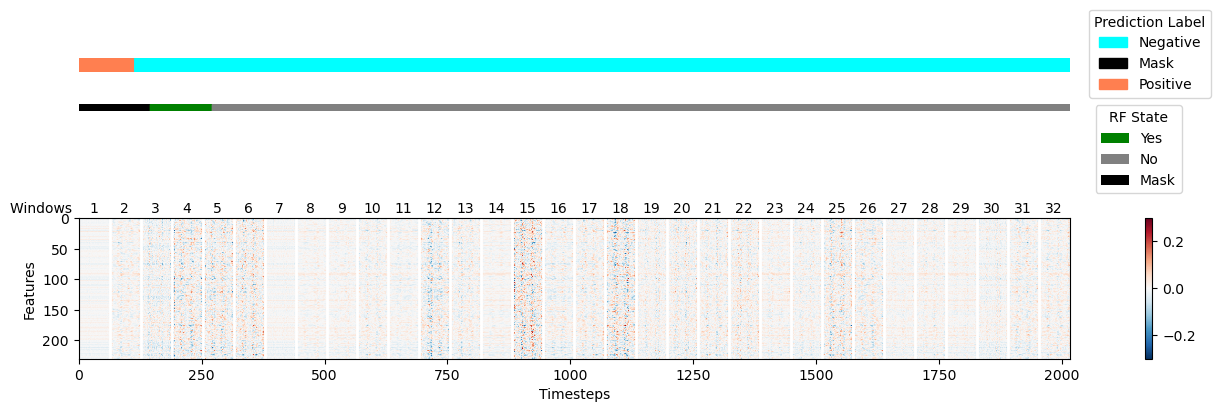

In [803]:
# dtest_x = mean_feature_time_maps_l1[pid]
## plot labels


fig, axs = plt.subplots(3, 1, figsize=(12, 4), gridspec_kw={'height_ratios': [1,0.15,3]}, sharex=True,layout='constrained')

color_map = {-1: '#00FFFF', 0: 'black', 1: '#FF7F50'}
colors = np.vectorize(color_map.get)(dtest_y_2d)
# Bar plot adjusted to match the width of the plot below
for i, color in enumerate(colors.flatten()):
    axs[0].plot([i, i+1], [0, 0], color=color, linewidth=10)
axs[0].axis('off')
legend_labels = {-1: "Negative", 0: "Mask", 1: "Positive"}
legend_handles = [Patch(color=color, label=legend_labels[label]) for label, color in color_map.items()]
# Adjusting xlim to ensure the top bar matches the width of the plot below
axs[0].set_xlim(0, 2016)
axs[0].legend(handles=legend_handles, loc='center right', title="Prediction Label",
              bbox_to_anchor=(1.15, 0.75),
              # ncol=len(legend_handles)
             )
#########################################################################
visualize_with_corrected_initial_mask(data=dtest_y_2d[0].tolist(), ax=axs[1])
# visualize_adjusted_shift_and_mask(data=dtest_y_2d[0].tolist(), ax=axs[1])
# pos1 = axs[1].get_position()  # gets the position of the current subplot
# pos2 = [pos1.x0, pos1.y0 - 0.1,  pos1.width, pos1.height]  # Lower the subplot a bit
# axs[1].set_position(pos2)  # set a new position
########################################################################
# Feature-Time Visualization adjusted
im = axs[2].imshow(masked_data, aspect='auto', cmap='RdBu_r',vmin=-0.3, vmax=0.3)
fig.colorbar(im, ax=axs[2], 
             location = 'right',
             orientation='vertical',
             # fraction=0.9,
             # aspect=2,
             pad=-0.06,
             # bbox_to_anchor=(0.1,0,1,1),
             # shrink=0.9,
             # anchor=(0.5, 0.5)
            )

steps = [63, 126, 189, 252, 315, 378, 441, 504, 567, 630, 693, 756, 819, 882, 945, 1008, 1071, 1134, 1197, 1260, 1323, 1386, 1449, 1512, 1575, \
         1638, 1701, 1764, 1827, 1890, 1953]

# Add vertical lines at specific steps
for step in steps:
    axs[2].axvline(x=step, color='white', linestyle='-', linewidth=2)
    
axs[2].text(-140, -10, 'Windows ', fontsize=10, color='black')
# Example range of numbers
numbers = range(1, 33)
x_positions = range(30, 2016,63)
y_position = -10

# Loop through each number and its respective x position to plot the text
for number, x in zip(numbers, x_positions):
    axs[2].text(x, y_position, str(number), ha='center',fontsize=10)
    
axs[2].set_xlabel('Timesteps')
axs[2].set_ylabel('Features')
# plt.tight_layout()
# plt.savefig('03_nwtworks_05.png', dpi=1200, bbox_inches='tight')
# plt.subplots_adjust(hspace=0.2)
plt.show()

In [804]:
dtest_x = mean_feature_time_maps_l2[pid]
dtest_y_2d = np.expand_dims(labels[pid], axis=0)
# dtest_y_2d
mask_bool = dtest_y_2d != 0
masked_data = np.where(mask_bool, dtest_x, 0)

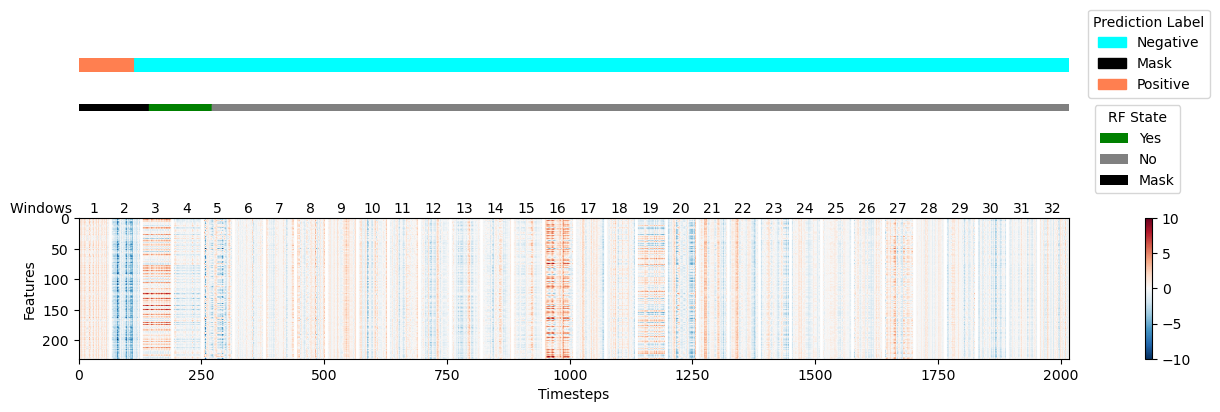

In [805]:
fig, axs = plt.subplots(3, 1, figsize=(12, 4), gridspec_kw={'height_ratios': [1,0.15,3]}, sharex=True,layout='constrained')

color_map = {-1: '#00FFFF', 0: 'black', 1: '#FF7F50'}
colors = np.vectorize(color_map.get)(dtest_y_2d)
# Bar plot adjusted to match the width of the plot below
for i, color in enumerate(colors.flatten()):
    axs[0].plot([i, i+1], [0, 0], color=color, linewidth=10)
axs[0].axis('off')
legend_labels = {-1: "Negative", 0: "Mask", 1: "Positive"}
legend_handles = [Patch(color=color, label=legend_labels[label]) for label, color in color_map.items()]
# Adjusting xlim to ensure the top bar matches the width of the plot below
axs[0].set_xlim(0, 2016)
axs[0].legend(handles=legend_handles, loc='center right', title="Prediction Label",
              bbox_to_anchor=(1.15, 0.75),
              # ncol=len(legend_handles)
             )
#########################################################################
visualize_with_corrected_initial_mask(data=dtest_y_2d[0].tolist(), ax=axs[1])
# visualize_adjusted_shift_and_mask(data=dtest_y_2d[0].tolist(), ax=axs[1])
# pos1 = axs[1].get_position()  # gets the position of the current subplot
# pos2 = [pos1.x0, pos1.y0 - 0.1,  pos1.width, pos1.height]  # Lower the subplot a bit
# axs[1].set_position(pos2)  # set a new position
########################################################################
# Feature-Time Visualization adjusted
im = axs[2].imshow(masked_data, aspect='auto', cmap='RdBu_r',vmin=-10, vmax=10)
fig.colorbar(im, ax=axs[2], 
             location = 'right',
             orientation='vertical',
             # fraction=0.9,
             # aspect=2,
             pad=-0.06,
             # bbox_to_anchor=(0.1,0,1,1),
             # shrink=0.9,
             # anchor=(0.5, 0.5)
            )

steps = [63, 126, 189, 252, 315, 378, 441, 504, 567, 630, 693, 756, 819, 882, 945, 1008, 1071, 1134, 1197, 1260, 1323, 1386, 1449, 1512, 1575, \
         1638, 1701, 1764, 1827, 1890, 1953]

# Add vertical lines at specific steps
for step in steps:
    axs[2].axvline(x=step, color='white', linestyle='-', linewidth=2)
    
axs[2].text(-140, -10, 'Windows ', fontsize=10, color='black')
# Example range of numbers
numbers = range(1, 33)
x_positions = range(30, 2016,63)
y_position = -10

# Loop through each number and its respective x position to plot the text
for number, x in zip(numbers, x_positions):
    axs[2].text(x, y_position, str(number), ha='center',fontsize=10)
    
axs[2].set_xlabel('Timesteps')
axs[2].set_ylabel('Features')
# plt.tight_layout()
# plt.savefig('03_nwtworks_05.png', dpi=1200, bbox_inches='tight')
# plt.subplots_adjust(hspace=0.2)
plt.show()

## now adjacency matrix

In [806]:
wadj_layer_1.shape, wadj_layer_2.shape

((64, 32, 231, 231), (64, 32, 231, 231))

In [807]:
## pid specific wadj
wadj_layer_1_pid = wadj_layer_1[pid]
wadj_layer_2_pid = wadj_layer_2[pid]

In [808]:
wadj_layer_1_pid.shape, wadj_layer_2_pid.shape

((32, 231, 231), (32, 231, 231))

In [809]:
# adj_matrices_l1 = adj_matrices[0]
# adj_matrices_l2 = adj_matrices[1]

In [810]:
# # Assuming adj_matrices_l1 is your list of adjacency matrices
# fig, axes = plt.subplots(4, 8, figsize=(12, 5))  # Adjust figsize to your preference

# for i, ax in enumerate(axes.flatten()):
#     # Normalize the matrix to have values between 0 and 1
#     # adj_matrix = adj_matrices_l1[0][i]
#     adj_matrix = wadj_layer_1_pid[i]
#     normalized_matrix = (adj_matrix - adj_matrix.min()) / (adj_matrix.max() - adj_matrix.min())
#     ax.axis('off')
#     # Plot the normalized matrix
#     # normalized_matrix = adj_matrices_l1[0][i]
#     im = ax.imshow(normalized_matrix, aspect='auto', 
#                    cmap='Reds', 
#                    # cmap='PuBu', 
#                    # vmin=0, vmax=1
#                   )
#     ax.set_title(f'Adj {i+1}',fontsize=4)
#     # ax.set_xlabel('Features')
#     # ax.set_ylabel('Features')

# # Optional: Add a colorbar to the right of the subplots
# plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)
# # print(normalized_matrix.shape)
# # plt.tight_layout()  # Adjust layout to make room for titles, labels, etc.
# plt.show()

In [811]:
# # Assuming adj_matrices_l1 is your list of adjacency matrices
# fig, axes = plt.subplots(4, 8, figsize=(12, 5))  # Adjust figsize to your preference

# for i, ax in enumerate(axes.flatten()):
#     # Normalize the matrix to have values between 0 and 1
#     # adj_matrix = adj_matrices_l1[0][i]
#     adj_matrix = wadj_layer_2_pid[i]
#     normalized_matrix = (adj_matrix - adj_matrix.min()) / (adj_matrix.max() - adj_matrix.min())
#     ax.axis('off')
#     # Plot the normalized matrix
#     # normalized_matrix = adj_matrices_l1[0][i]
#     im = ax.imshow(normalized_matrix, aspect='auto', 
#                    # cmap='Reds', 
#                    cmap='RdBu_r', 
#                    # cmap='viridis',
#                    # vmin=0, vmax=1
#                   )
#     ax.set_title(f'Adj {i+1}',fontsize=4)
#     # ax.set_xlabel('Features')
#     # ax.set_ylabel('Features')

# # Optional: Add a colorbar to the right of the subplots
# plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)
# print(normalized_matrix.shape)
# # plt.tight_layout()  # Adjust layout to make room for titles, labels, etc.
# plt.show()

In [812]:
# pid=0
# # Assuming adj_matrices_l1 is your list of adjacency matrices
# fig, axes = plt.subplots(4, 8, figsize=(12, 5))  # Adjust figsize to your preference

# for i, ax in enumerate(axes.flatten()):
#     # Normalize the matrix to have values between 0 and 1
#     # adj_matrix = adj_matrices_l1[0][i]
#     adj_matrix = wadj_matrices_l1[pid][i]
#     normalized_matrix = (adj_matrix - adj_matrix.min()) / (adj_matrix.max() - adj_matrix.min())
#     ax.axis('off')
#     # Plot the normalized matrix
#     # normalized_matrix = adj_matrices_l1[0][i]
#     im = ax.imshow(normalized_matrix, aspect='auto', 
#                    cmap='Reds', 
#                    # cmap='PuBu', 
#                    # vmin=0, vmax=1
#                   )
#     ax.set_title(f'Adj {i+1}',fontsize=4)
#     # ax.set_xlabel('Features')
#     # ax.set_ylabel('Features')

# # Optional: Add a colorbar to the right of the subplots
# plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)
# # print(normalized_matrix.shape)
# # plt.tight_layout()  # Adjust layout to make room for titles, labels, etc.
# plt.show()

In [813]:
# # Initialize global minimum and maximum with the first matrix's values to start comparisons
# global_min = wadj_matrices_l1[pid][0].min()
# global_max = wadj_matrices_l1[pid][0].max()

# # Find global minimum and maximum
# for i in range(len(wadj_matrices_l1[pid])):
#     adj_matrix = wadj_matrices_l1[pid][i]
#     global_min = min(global_min, adj_matrix.min())
#     global_max = max(global_max, adj_matrix.max())

In [814]:
# pid=0
# # Assuming adj_matrices_l1 is your list of adjacency matrices
# fig, axes = plt.subplots(4, 8, figsize=(12, 5))  # Adjust figsize to your preference

# for i, ax in enumerate(axes.flatten()):
#     # Normalize the matrix to have values between 0 and 1
#     # adj_matrix = adj_matrices_l1[0][i]
#     adj_matrix = wadj_matrices_l1[pid][i]
#     normalized_matrix = (adj_matrix - global_min) / (global_max - global_min)
#     ax.axis('off')
#     # Plot the normalized matrix
#     # normalized_matrix = adj_matrices_l1[0][i]
#     im = ax.imshow(normalized_matrix, aspect='auto', 
#                    cmap='Reds', 
#                    # cmap='PuBu', 
#                    # vmin=0, vmax=1
#                   )
#     ax.set_title(f'Adj {i+1}',fontsize=4)
#     # ax.set_xlabel('Features')
#     # ax.set_ylabel('Features')

# # Optional: Add a colorbar to the right of the subplots
# plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)
# # print(normalized_matrix.shape)
# # plt.tight_layout()  # Adjust layout to make room for titles, labels, etc.
# plt.show()

In [815]:
# pid=0
# # Assuming adj_matrices_l1 is your list of adjacency matrices
# fig, axes = plt.subplots(4, 8, figsize=(12, 5))  # Adjust figsize to your preference

# for i, ax in enumerate(axes.flatten()):
#     # Normalize the matrix to have values between 0 and 1
#     # adj_matrix = adj_matrices_l1[0][i]
#     adj_matrix = wadj_matrices_l2[pid][i]
#     normalized_matrix = (adj_matrix - adj_matrix.min()) / (adj_matrix.max() - adj_matrix.min())
#     ax.axis('off')
#     # Plot the normalized matrix
#     # normalized_matrix = adj_matrices_l1[0][i]
#     im = ax.imshow(normalized_matrix, aspect='auto', 
#                    cmap='Reds', 
#                    # cmap='PuBu', 
#                    # vmin=0, vmax=1
#                   )
#     ax.set_title(f'Adj {i+1}',fontsize=4)
#     # ax.set_xlabel('Features')
#     # ax.set_ylabel('Features')

# # Optional: Add a colorbar to the right of the subplots
# plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)
# # print(normalized_matrix.shape)
# # plt.tight_layout()  # Adjust layout to make room for titles, labels, etc.
# plt.show()

In [816]:
# # Initialize global minimum and maximum with the first matrix's values to start comparisons
# global_min = wadj_matrices_l2[pid][0].min()
# global_max = wadj_matrices_l2[pid][0].max()

# # Find global minimum and maximum
# for i in range(len(wadj_matrices_l2[pid])):
#     adj_matrix = wadj_matrices_l2[pid][i]
#     global_min = min(global_min, adj_matrix.min())
#     global_max = max(global_max, adj_matrix.max())

In [817]:
# pid=0
# # Assuming adj_matrices_l1 is your list of adjacency matrices
# fig, axes = plt.subplots(4, 8, figsize=(12, 5))  # Adjust figsize to your preference

# for i, ax in enumerate(axes.flatten()):
#     # Normalize the matrix to have values between 0 and 1
#     # adj_matrix = adj_matrices_l1[0][i]
#     adj_matrix = wadj_matrices_l2[pid][i]
#     normalized_matrix = (adj_matrix - global_min) / (global_max - global_min)
#     ax.axis('off')
#     # Plot the normalized matrix
#     # normalized_matrix = adj_matrices_l1[0][i]
#     im = ax.imshow(normalized_matrix, aspect='auto', 
#                    cmap='Reds', 
#                    # cmap='PuBu', 
#                    # vmin=0, vmax=1
#                   )
#     ax.set_title(f'Adj {i+1}',fontsize=4)
#     # ax.set_xlabel('Features')
#     # ax.set_ylabel('Features')

# # Optional: Add a colorbar to the right of the subplots
# plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)
# # print(normalized_matrix.shape)
# # plt.tight_layout()  # Adjust layout to make room for titles, labels, etc.
# plt.show()

## convert these matrices to nice looking graphs

In [818]:
import pandas as pd

In [942]:
varname  = pd.read_csv('varname_clean.csv')

In [943]:
var_names = varname['cleanshortname'].values.tolist()

In [944]:
### for pid 44; af slot is 3-4-14 so index is 2,3-13
### for pid 55; af slot is 16-17-18-29-30 so index is 15,16,17,28,29
### for pid 51; af slot is 3-4 so index is 2,3

#########################################################
### for pid 44; af slot is 3-4 13-14 so index is 2,3 12-13
### for pid 55; af label is in 14-15 27-28 so graph index is 13-14 26-27
### for pid 51; af slot is 3-4 so index is 2,3
pid 

51

In [945]:
wadj_layer_1_pid.shape, wadj_layer_2_pid.shape

((32, 231, 231), (32, 231, 231))

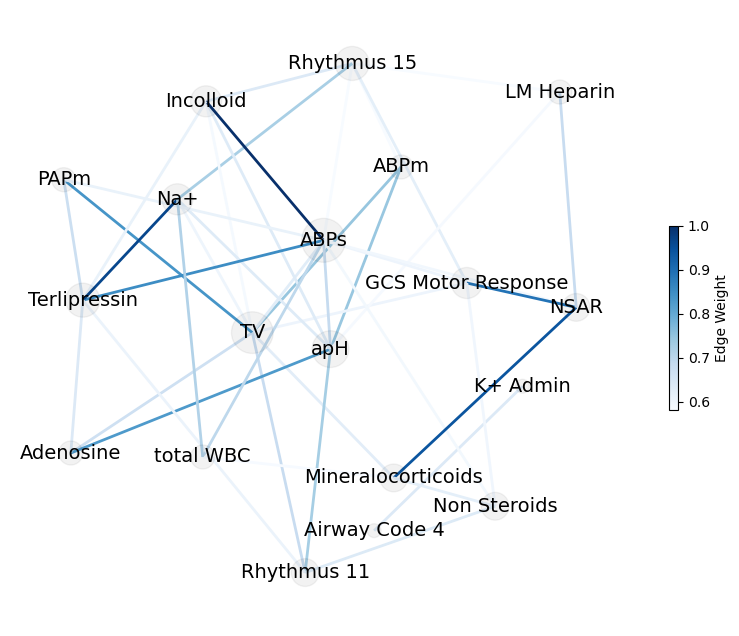

In [947]:
timeslot = 2

adj_matrix = wadj_layer_1_pid[timeslot]
normalized_matrix = (adj_matrix - adj_matrix.min()) / (adj_matrix.max() - adj_matrix.min())
# Assuming normalized_matrix is defined
# normalized_matrix = ...
node_names_list = var_names 
# Define a threshold for including edges
threshold = 0.58  # Example threshold value

# Create a graph from the adjacency matrix
G = nx.Graph()
node_names = var_names
# Add weighted edges based on the adjacency matrix
for i in range(len(normalized_matrix)):
    for j in range(i+1, len(normalized_matrix)):
        weight = normalized_matrix[i, j]
        if weight > threshold:  # Check if weight is above the threshold
            G.add_edge(i, j, weight=weight)

# Now extract the weights and normalize them
edge_weights = np.array([G[u][v]['weight'] for u, v in G.edges()])
weights_normalized = (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min())

# Remove isolated nodes (optional)
G.remove_nodes_from(list(nx.isolates(G)))

nodes_with_some_neighbor = [node for node, degree in dict(G.degree()).items() if degree in [1,2,3]]
# Then, remove these nodes from the graph
G.remove_nodes_from(nodes_with_some_neighbor)
G.remove_nodes_from(list(nx.isolates(G)))
# Adjust the node_names dictionary to only include nodes present in the graph after filtering
filtered_node_names = {node: node_names[node] for node in G.nodes()}

# Create a color map to map the normalized weights to colors
cmap = cm.Blues  # You can choose a color map that you prefer

# Create a list of colors for each edge
edge_colors = [cmap(w) for w in weights_normalized]


# Plot the graph
plt.figure(figsize=(10, 8))  # Increase figure size for better clarity
# pos = nx.spring_layout(G)  # Use spring layout for node positions
pos = nx.kamada_kawai_layout(G)  # Use spring layout for node positions

d = dict(G.degree)
# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='k', node_size=[d[k]*100 for k in d], alpha=0.05)

# Draw edges with colors based on weights
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2)

# If you want to add a color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=edge_weights.min(), vmax=edge_weights.max()))
sm.set_array([])
plt.colorbar(sm, label='Edge Weight',shrink=0.3,)

# # Draw labels
# labels = {i: f"Node {i+1}" for i in range(len(normalized_matrix))}  # Replace with your actual labels
nx.draw_networkx_labels(G, pos, labels=filtered_node_names, font_size=14,
                        # font_weight='bold',
                        font_color='k')

plt.axis('off')
plt.show()

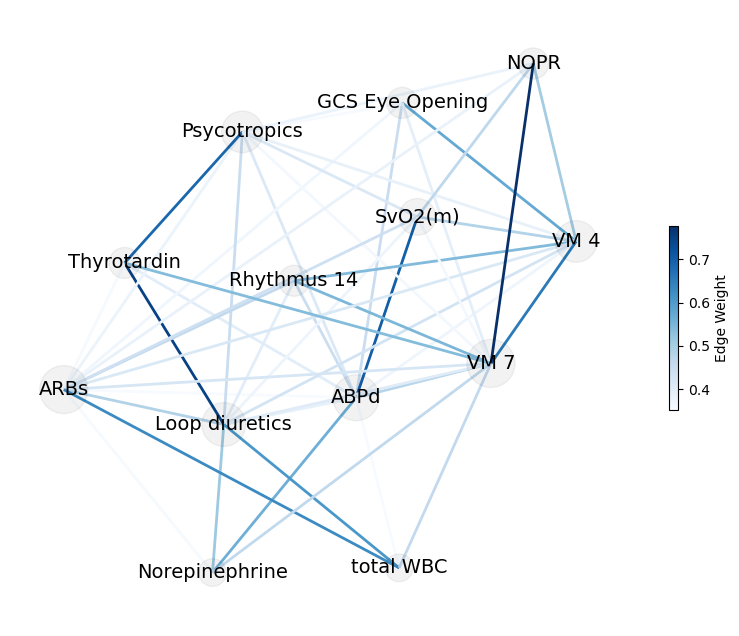

In [948]:
timeslot = 2

adj_matrix = wadj_layer_2_pid[timeslot]
normalized_matrix = (adj_matrix - adj_matrix.min()) / (adj_matrix.max() - adj_matrix.min())
# Assuming normalized_matrix is defined
# normalized_matrix = ...
node_names_list = var_names 
# Define a threshold for including edges
threshold = 0.35# Example threshold value

# Create a graph from the adjacency matrix
G = nx.Graph()
node_names = var_names
# Add weighted edges based on the adjacency matrix
for i in range(len(normalized_matrix)):
    for j in range(i+1, len(normalized_matrix)):
        weight = normalized_matrix[i, j]
        if weight > threshold:  # Check if weight is above the threshold
            G.add_edge(i, j, weight=weight)

# Now extract the weights and normalize them
edge_weights = np.array([G[u][v]['weight'] for u, v in G.edges()])
weights_normalized = (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min())

# Remove isolated nodes (optional)
G.remove_nodes_from(list(nx.isolates(G)))

nodes_with_some_neighbor = [node for node, degree in dict(G.degree()).items() if degree in [1,2]]
# Then, remove these nodes from the graph
G.remove_nodes_from(nodes_with_some_neighbor)
G.remove_nodes_from(list(nx.isolates(G)))
# Adjust the node_names dictionary to only include nodes present in the graph after filtering
filtered_node_names = {node: node_names[node] for node in G.nodes()}



# Create a color map to map the normalized weights to colors
cmap = cm.Blues  # You can choose a color map that you prefer

# Create a list of colors for each edge
edge_colors = [cmap(w) for w in weights_normalized]


# Plot the graph
plt.figure(figsize=(10, 8))  # Increase figure size for better clarity
# pos = nx.spring_layout(G)  # Use spring layout for node positions
pos = nx.kamada_kawai_layout(G)  # Use spring layout for node positions
# pos = nx.random_layout(G)  # Use spring layout for node positions

d = dict(G.degree)
# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='k', node_size=[d[k]*100 for k in d], alpha=0.05)

# Draw edges with colors based on weights
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2)

# If you want to add a color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=edge_weights.min(), vmax=edge_weights.max()))
sm.set_array([])
plt.colorbar(sm, label='Edge Weight',shrink=0.3)

# # Draw labels
# labels = {i: f"Node {i+1}" for i in range(len(normalized_matrix))}  # Replace with your actual labels
nx.draw_networkx_labels(G, pos, labels=filtered_node_names, font_size=14,font_color='k')

plt.axis('off')
plt.show()

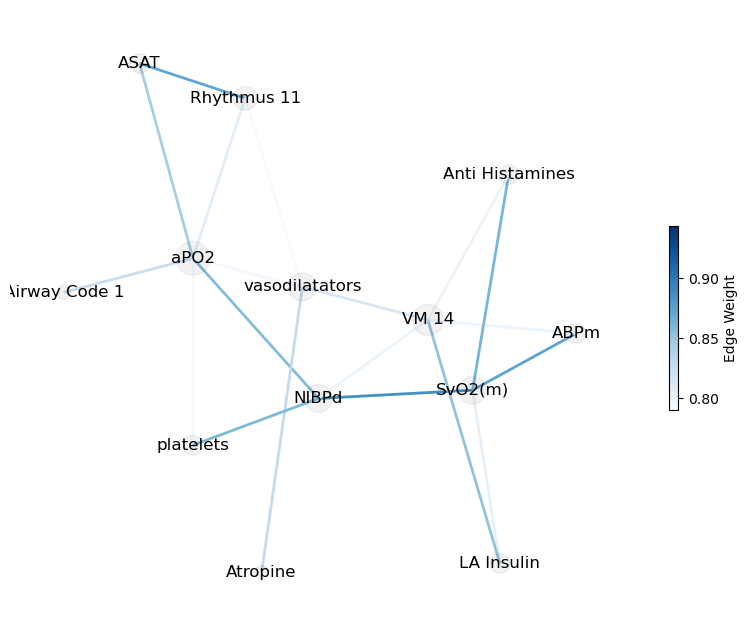

In [952]:
timeslot = 3

adj_matrix = wadj_layer_1_pid[timeslot]
normalized_matrix = (adj_matrix - adj_matrix.min()) / (adj_matrix.max() - adj_matrix.min())
# Assuming normalized_matrix is defined
# normalized_matrix = ...
node_names_list = var_names 
# Define a threshold for including edges
threshold = 0.79  # Example threshold value

# Create a graph from the adjacency matrix
G = nx.Graph()
node_names = var_names
# Add weighted edges based on the adjacency matrix
for i in range(len(normalized_matrix)):
    for j in range(i+1, len(normalized_matrix)):
        weight = normalized_matrix[i, j]
        if weight > threshold:  # Check if weight is above the threshold
            G.add_edge(i, j, weight=weight)

# Now extract the weights and normalize them
edge_weights = np.array([G[u][v]['weight'] for u, v in G.edges()])
weights_normalized = (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min())

if G.has_node(106):
    G.remove_node(106)
    
# Remove isolated nodes (optional)
G.remove_nodes_from(list(nx.isolates(G)))

nodes_with_some_neighbor = [node for node, degree in dict(G.degree()).items() if degree in [1,2]]
# Then, remove these nodes from the graph
G.remove_nodes_from(nodes_with_some_neighbor)

G.remove_nodes_from(list(nx.isolates(G)))

# Adjust the node_names dictionary to only include nodes present in the graph after filtering
filtered_node_names = {node: node_names[node] for node in G.nodes()}


# Create a color map to map the normalized weights to colors
cmap = cm.Blues  # You can choose a color map that you prefer

# Create a list of colors for each edge
edge_colors = [cmap(w) for w in weights_normalized]


# Plot the graph
plt.figure(figsize=(10, 8))  # Increase figure size for better clarity
# pos = nx.spring_layout(G)  # Use spring layout for node positions
pos = nx.kamada_kawai_layout(G)  # Use spring layout for node positions

d = dict(G.degree)
# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='k', node_size=[d[k]*100 for k in d], alpha=0.05)

# Draw edges with colors based on weights
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2)

# If you want to add a color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=edge_weights.min(), vmax=edge_weights.max()))
sm.set_array([])
plt.colorbar(sm, label='Edge Weight',shrink=0.3)

# # Draw labels
# labels = {i: f"Node {i+1}" for i in range(len(normalized_matrix))}  # Replace with your actual labels
nx.draw_networkx_labels(G, pos, labels=filtered_node_names, font_size=12)

plt.axis('off')
plt.show()

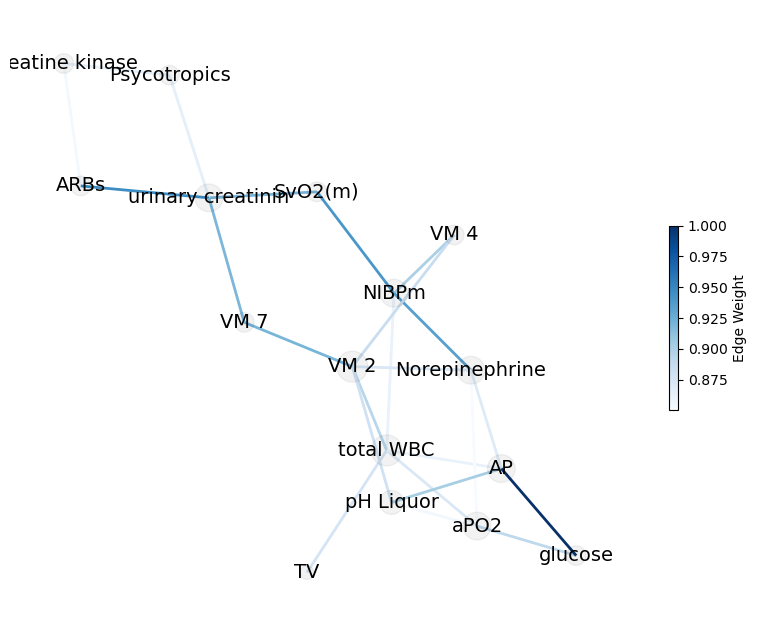

In [969]:
timeslot = 3

adj_matrix = wadj_layer_2_pid[timeslot]
normalized_matrix = (adj_matrix - adj_matrix.min()) / (adj_matrix.max() - adj_matrix.min())
# Assuming normalized_matrix is defined
# normalized_matrix = ...
node_names_list = var_names 
# Define a threshold for including edges
threshold = 0.85# Example threshold value

# Create a graph from the adjacency matrix
G = nx.Graph()
node_names = var_names
# Add weighted edges based on the adjacency matrix
for i in range(len(normalized_matrix)):
    for j in range(i+1, len(normalized_matrix)):
        weight = normalized_matrix[i, j]
        if weight > threshold:  # Check if weight is above the threshold
            G.add_edge(i, j, weight=weight)

# Now extract the weights and normalize them
edge_weights = np.array([G[u][v]['weight'] for u, v in G.edges()])
weights_normalized = (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min())

# Remove isolated nodes (optional)
G.remove_nodes_from(list(nx.isolates(G)))

nodes_with_some_neighbor = [node for node, degree in dict(G.degree()).items() if degree in [1]]
# Then, remove these nodes from the graph
G.remove_nodes_from(nodes_with_some_neighbor)

G.remove_nodes_from(list(nx.isolates(G)))
# Adjust the node_names dictionary to only include nodes present in the graph after filtering
filtered_node_names = {node: node_names[node] for node in G.nodes()}



# Create a color map to map the normalized weights to colors
cmap = cm.Blues  # You can choose a color map that you prefer

# Create a list of colors for each edge
edge_colors = [cmap(w) for w in weights_normalized]


# Plot the graph
plt.figure(figsize=(10, 8))  # Increase figure size for better clarity
# pos = nx.spring_layout(G)  # Use spring layout for node positions
pos = nx.kamada_kawai_layout(G)  # Use spring layout for node positions
# pos = nx.random_layout(G)  # Use spring layout for node positions

d = dict(G.degree)
# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='k', node_size=[d[k]*100 for k in d], alpha=0.05)

# Draw edges with colors based on weights
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2)

# If you want to add a color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=edge_weights.min(), vmax=edge_weights.max()))
sm.set_array([])
plt.colorbar(sm, label='Edge Weight',shrink=0.3)

# # Draw labels
# labels = {i: f"Node {i+1}" for i in range(len(normalized_matrix))}  # Replace with your actual labels
nx.draw_networkx_labels(G, pos, labels=filtered_node_names, font_size=14)

plt.axis('off')
plt.show()